# HR аналитика. Предсказание уровня удовлетворенности работников и оттока кадров

Компании требуется спрогнозировать удовлетворенность сотрудников и отток кадров чтобы минимизировать риски, связанные с уходом сотрудников. Для этого нужны две модели машинного обучения, соответствующие установленным критериям

## Цели исследования

* Изучить и обработать предоставленные данные для первой задачи
* Создать метрику SMAPE для оценки модели
* Обучить несколько моделей и выбрать лучшую модель для предсказания уровня удовлетворенности, удовлетворяющую запросу SMAPE не больше 15%
* Изучить важность признаков для модели, сделать рекомендации
* Изучить и обработать набор данных для второй задачи
* Составить портрет уволившегося сотрудника
* При необходимости расширить набор данных
* Обучить несколько моделей и выбрать лучшую модель для предсказания оттока кадров, показавшую ROC-AUC не менее 0,91
* Изучить важность признаков для модели, сделать рекомендации

## Ход исследования

* Подготовка данных: загрузка и изучение информации о предоставленных датасетах.
* Предобработка данных: при необходимости изменение названий столбцов, изменение типов данных, обработка дубликатов.
* Исследовательский анализ данных: обработка выбросов и аномалий.
* Корреляционный анализ: определение взаимосвязи признаков.
* Выбор модели для задачи регрессии: создать метрику SMAPE для выбора лучшей модели, подобрать лучший тип модели и её гиперпараметры.
* Анализ важности признаков: выявить наиболее и наименее важные признаки для модели.
* Подготовка, предобработка и исследовательский анализ данных для задачи классификации.
* Анализ данных: описать портрет уволившегося сотрудника, определить влияет ли на него уровень удовлетворенности.
* Выбор модели для задачи классификации: подобрать лучший тип модели и её гиперпараметры для прогноза оттока сотрудников.
* Вывод: сделать выводы о моделях и их результатах работы, дать рекомендации HR отделу.

## Исследование №1

Импорт библиотек, объявление констант

In [1]:
!pip install --upgrade scikit-learn -q

In [2]:
!pip install shap -q

In [3]:
!pip install phik -q

In [4]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import(
    OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, 
    LabelEncoder, RobustScaler
)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC 
from sklearn.metrics import(
    roc_auc_score, make_scorer
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import shap
import phik

In [5]:
warnings.filterwarnings('ignore')

In [6]:
RANDOM_STATE = 42

### Загрузка данных

Сохраним три датасета, настроим показ всех колонок, выведем первые строчки и информацию о каждом

In [7]:
pd.set_option('display.max_columns', None)
data_first = pd.read_csv('datasets/train_job_satisfaction_rate.csv')
X_test_first = pd.read_csv('datasets/test_features.csv')
y_test_first = pd.read_csv('datasets/test_target_job_satisfaction_rate.csv')

In [8]:
display(data_first.head(5))
data_first.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [9]:
display(X_test_first.head(5))
X_test_first.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [10]:
display(y_test_first.head(5))
y_test_first.info()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Названия столбцов, типы данных и сами данные записаны корректно. В столбцах с отделом и уровнем должности есть несколько пропусков в тренировочных и тестовых данных, обработаем их в пайплайне на этапе обучения модели

### Предобработка данных

Проверим явные дубликаты в id пользователей

In [11]:
display(
    data_first['id'].duplicated().sum(), 
    X_test_first['id'].duplicated().sum(),
    y_test_first['id'].duplicated().sum()
)

0

0

0

Пользователи в датасетах с тестовыми признаками и тестовым таргетом отсортированы по-разному, отсортируем их одинаково и проверим, все ли совпадают

In [12]:
X_test_first = X_test_first.sort_values(by='id').reset_index(drop=True) 
y_test_first = y_test_first.sort_values(by='id').reset_index(drop=True)

In [13]:
(X_test_first['id'] == y_test_first['id']).sum()

2000

Выведем все уникальные значения категориальных признаков для поиска опечаток

In [14]:
display(
    data_first['dept'].unique(),
    X_test_first['dept'].unique(),
    data_first['level'].unique(),
    X_test_first['level'].unique(),
    data_first['workload'].unique(),
    X_test_first['workload'].unique(),
    data_first['last_year_promo'].unique(),
    X_test_first['last_year_promo'].unique(),
    data_first['last_year_violations'].unique(),
    X_test_first['last_year_violations'].unique()
)

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

array(['hr', 'marketing', 'purchasing', 'sales', 'technology', nan, ' '],
      dtype=object)

array(['junior', 'middle', 'sinior', nan], dtype=object)

array(['junior', 'middle', 'sinior', nan], dtype=object)

array(['medium', 'high', 'low'], dtype=object)

array(['low', 'high', 'medium', ' '], dtype=object)

array(['no', 'yes'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['no', 'yes'], dtype=object)

В столбцах с рабочей нагрузкой и отделом встречаются пробелы, посмотрим на этих пользователей и их количество

In [15]:
display(X_test_first.query('dept == " "'))
X_test_first.query('workload == " "')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1609,822186,,middle,medium,3,no,no,4,38400


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1100,590867,marketing,junior,,4,no,no,4,28800


Заменим пробелы на nan, в дальнейшем обработаем их в пайплайне

In [16]:
X_test_first.loc[X_test_first['workload'] == ' ', 'workload'] = np.nan
X_test_first['workload'].unique()

array(['low', 'high', 'medium', nan], dtype=object)

In [17]:
X_test_first.loc[X_test_first['dept'] == ' ', 'dept'] = np.nan
X_test_first['dept'].unique()

array(['hr', 'marketing', 'purchasing', 'sales', 'technology', nan],
      dtype=object)

В результате предобработки мы отсортировали тестовые датафреймы в одинаковом порядке и убрали пробелы из названий категорий

### Исследовательский анализ данных

Функции для построения графиков

In [18]:
def dia_bar_pct (col, title):
    name = 'Доля увольнений по '
    heigh = data_second.query('quit == "yes"').groupby(col).agg('sum')['id'] / \
    data_second.groupby(col).agg('sum')['id'] 
    bars = heigh.index
    x_pos = np.arange(len(bars))
    plt.bar(x_pos, heigh, label=title)
    plt.xticks(x_pos, bars, rotation=90)
    plt.grid(True, axis='y')
    plt.title(name+title)
    plt.ylabel('Доля уволившихся')

In [19]:
def dia_hist_box (df, col, title):
    fig, (ax_box, ax_hist) = plt.subplots(
        2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}
    )
    sns.boxplot(x=df[col], orient="h", ax=ax_box)
    sns.histplot(data=df, x=col, ax=ax_hist)
    ax_box.set(xlabel='')
    ax_box.set_title(title)
    plt.xlabel(col)
    plt.ylabel('Количество работников')
    plt.grid(True)

In [20]:
def bar (df, col, name, hue=None):
    sns.countplot(x=col, data=df, hue=hue)
    plt.title(col+name)
    plt.ylabel('Количество работников')
    plt.xlabel(' ')
    plt.grid(True)

In [21]:
def pie (df, col, name):
    plt.pie(
        df[col].value_counts(), 
        labels=df[col].value_counts().index,     
        autopct='%.1f',  
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }
    )
    plt.title(col+name)

Изучим описание количественных признаков

In [22]:
data_first.drop(columns='id').describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


In [23]:
X_test_first.drop(columns='id').describe()

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


Аномальных значений не обнаружено, среднее значение зарплаты заметно выше медианного, скорее всего там присутствуют выбросы

Сравним распределение категориальных признаков для тренировочных и тестовых данных. Если они будут сильно отличаться, то модель легко переобучится и нужно будет учитывать этот момент при подборе параметров

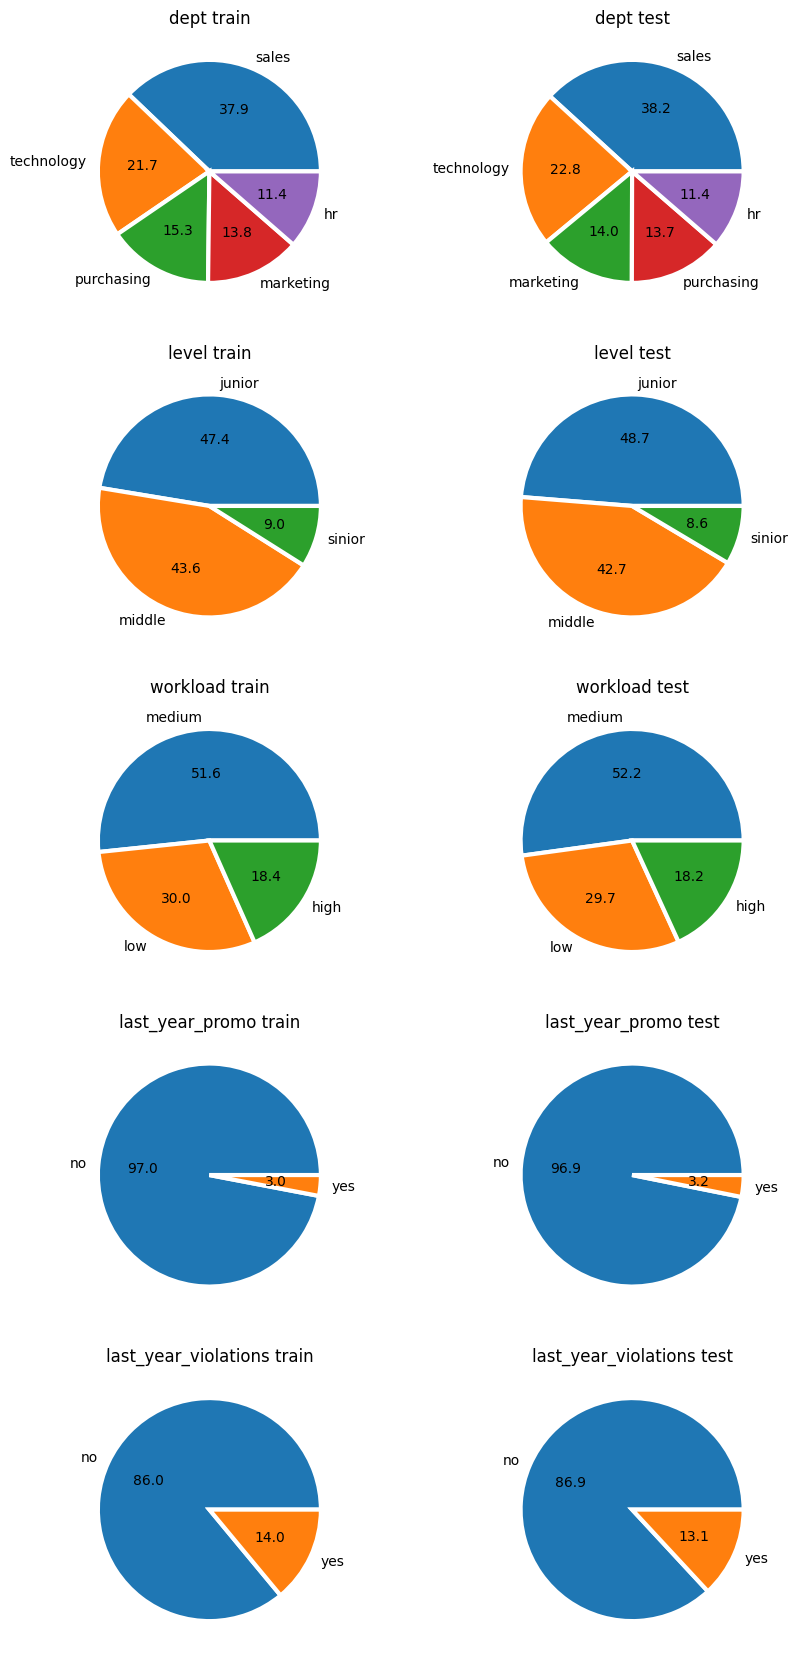

In [24]:
col = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
plt.figure(figsize=(10, 21))
plt.title('Тренировочные и тестовые категориальные признаки')
for i in range(0, len(col)*2, 2):
    for j in range(0, 2):
        plt.subplot(len(col), 2, (i+j+1))
        if j == 0:
            pie(data_first, col[int(i/2)], ' train')
        else:
            pie(X_test_first, col[int(i/2)], ' test')
plt.show()  

Признаки распределены почти одинаково. В признаках повышения и нарушения за последний год имеется сильный дисбаланс

Рассмотрим дискретные численные признаки для тех же наборов данных

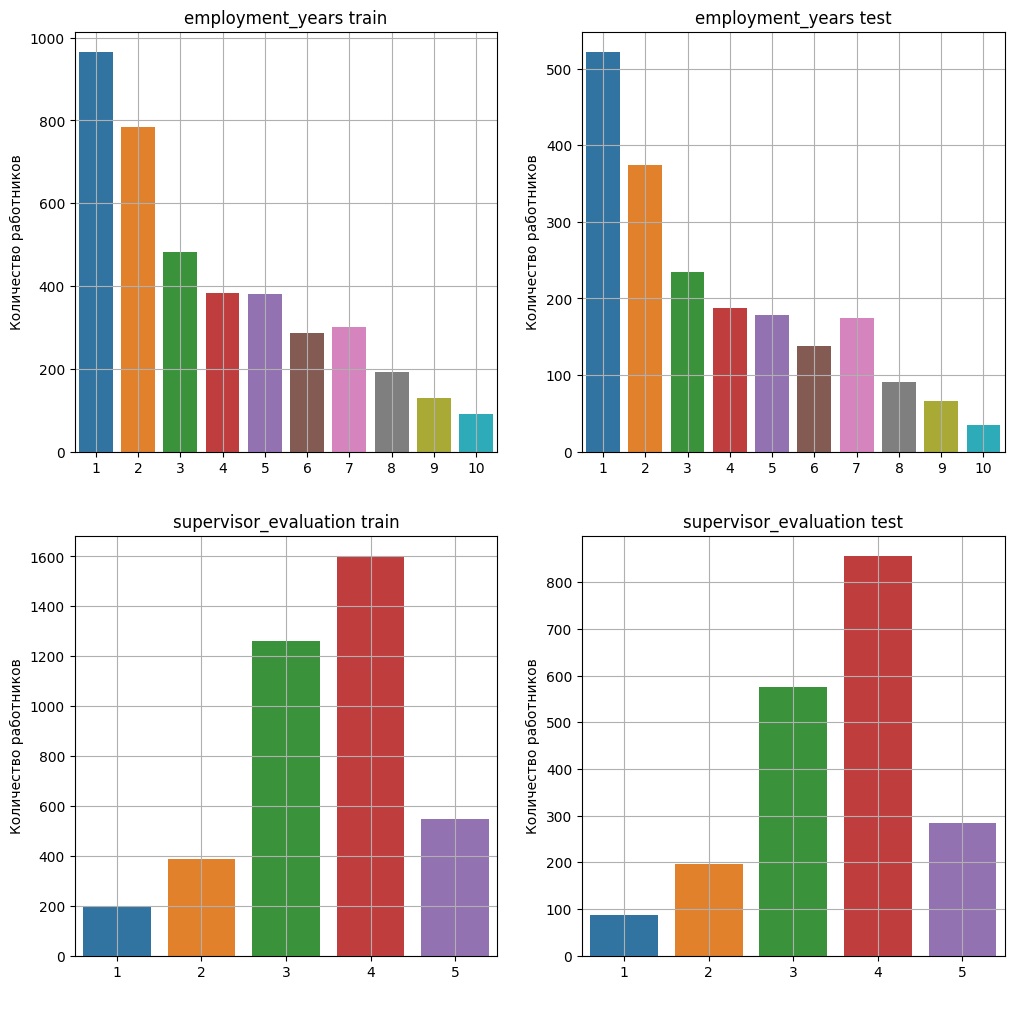

In [25]:
col = ['employment_years', 'supervisor_evaluation']
plt.figure(figsize=(12, 12))
for i in range(0, len(col)*2, 2):
    for j in range(0, 2):
        plt.subplot(len(col), 2, (i+j+1))
        if j == 0:
            bar(data_first, col[int(i/2)], ' train')
        else:
            bar(X_test_first, col[int(i/2)], ' test')
plt.show() 

Признаки также распределены схожим образом, непрерывные рассмотрим на гистограмме и боксплоте, также рассмотрим таргетный признак

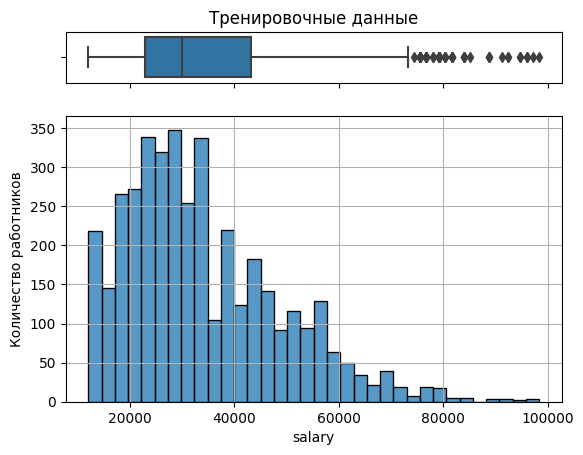

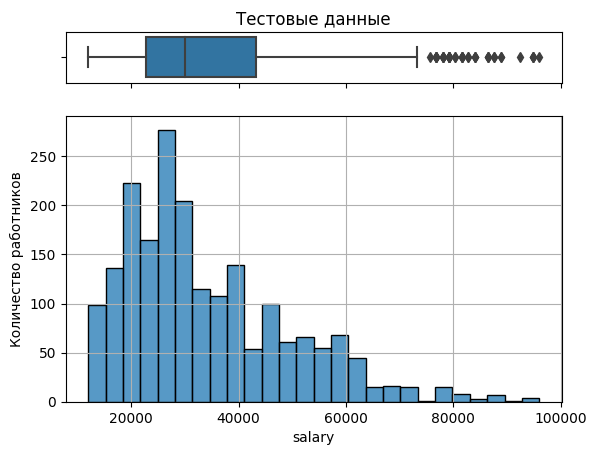

In [26]:
dia_hist_box(data_first, 'salary', 'Тренировочные данные')
dia_hist_box(X_test_first, 'salary', 'Тестовые данные')

В обоих случаях видны выбросы в большую сторону, что нормально при рассмотрении зарплаты всех сотрудников компании. Будем это учитывать при обучении модели, по возможности использовать робастные решения

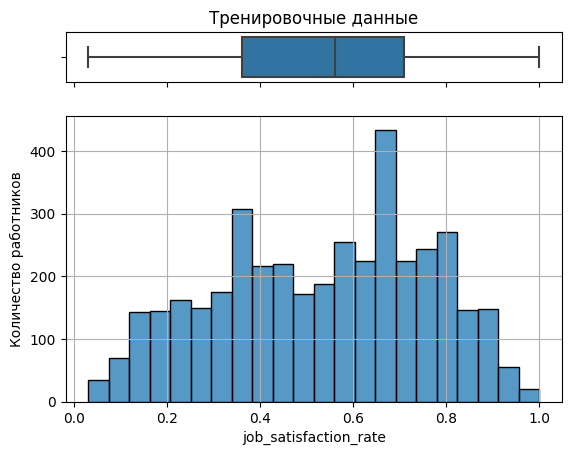

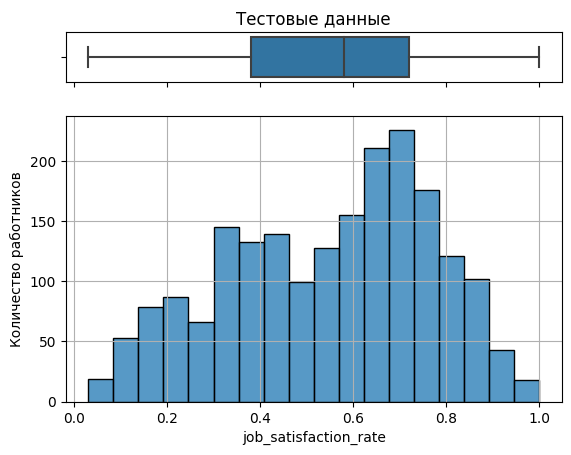

In [27]:
dia_hist_box(data_first, 'job_satisfaction_rate', 'Тренировочные данные')
dia_hist_box(y_test_first, 'job_satisfaction_rate', 'Тестовые данные')

Тестовые данные распределены схожим образом, имеется бимодальность

В результате исследовательского анализа выяснилось, что тренировочные и тестовые данные распределены схожим образом, а значит быстрое переобучение модели не грозит. Также был обнаружен признак с выбросами, а значит стоит использовать робастные инструменты

### Корреляционный анализ

Построим матрицу корреляции. Поскольку имеется много категориальных признаков, используем библиотеку phik чтобы посмотреть на зависимости среди всех признаков

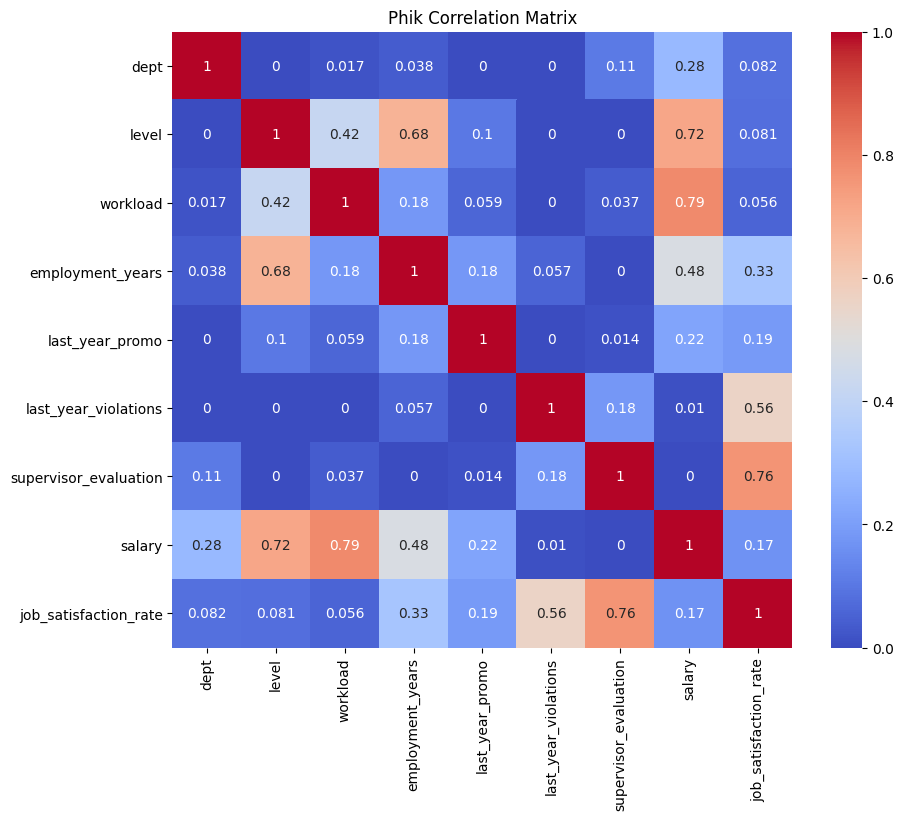

In [28]:
corr_matrix = data_first.drop(columns='id').phik_matrix(
    interval_cols=['salary', 'job_satisfaction_rate'] 
)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phik Correlation Matrix')
plt.show()

Мультиколлинеарности не обнаружено, при этом некоторые признаки почти не влияют на целевой

### Обучение модели

Создадим списки категориальных и количественных переменных, исключив таргет и id. Поделим тренировочный датасет на входные признаки X и целевой признак y. Поскольку имееются отдельные тренировочные данные, а валидация будет проводится при подборе параметров методом кросс-валидации, можно не выделять тренировочную выборку из обучающих данных.

In [29]:
cat_columns = data_first.select_dtypes(exclude='number').columns.tolist()
num_columns = data_first.select_dtypes(include='number').drop(
    columns=['id', 'job_satisfaction_rate']
).columns.tolist()
X = data_first[num_columns + cat_columns]
y = data_first['job_satisfaction_rate']
display(X.shape, y.shape)

(4000, 8)

(4000,)

Создадим тестовые признаки из предоставленых данных

In [30]:
X_test = X_test_first[num_columns + cat_columns]
y_test = y_test_first['job_satisfaction_rate']

Название отдела будем кодировать OneHotEncoder, поскольку их нельзя ранжировать. Бинарные признаки также будем кодировать им. Остальные категории закодируем OrdinalEncoder

In [31]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']

Поскольку пропущеные значения могут быть результатом технического сбоя, либо наличием другого отдела и должности, которые не записываются в датасет, будем заполнять пропуски с помощью заглушки и самым часто встречающимся значением. Для этого создадим два пайплайна

In [32]:
ohe_pipe_mf = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
     ('simpleImputer_after_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
    )

ord_pipe_mf = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor_mf = ColumnTransformer(
    [('ohe', ohe_pipe_mf, ohe_columns),
     ('ord', ord_pipe_mf, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final_mf = Pipeline([
    ('preprocessor', data_preprocessor_mf),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [33]:
ohe_pipe_const = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(
        missing_values=np.nan, 
        strategy='constant', 
        fill_value='unknown'
    )),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist', sparse_output=False)),
     ('simpleImputer_after_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
    )

ord_pipe_const = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(
        missing_values=np.nan, 
        strategy='constant', 
        fill_value='unknown'
    )),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['unknown', 'junior', 'middle', 'sinior'],
                    ['unknown', 'low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=-1
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor_const = ColumnTransformer(
    [('ohe', ohe_pipe_const, ohe_columns),
     ('ord', ord_pipe_const, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final_const = Pipeline([
    ('preprocessor', data_preprocessor_const),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

Создадим функцию для подсчета метрики SMAPE и создадим метрику с помощью make_scorer, указав что мы ищем наименьшее значение

In [34]:
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(
        np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2)
    )

In [35]:
smape_score = make_scorer(
    smape,
    greater_is_better=False
) 

Для задачи регрессии подойдут модели линейной регрессии и регрессионное дерево решений, будем искать параметры для каждой отдельно с заменой пропусков на заглушку и самое частое значение. Для борьбы с выбросами помимо StandardScaler будем подбирать RobustScaler. Чтобы точно не пропустить лучшую модель, используем GridSearch. Поскольку параметр greater_is_better=False меняет знак метрики, при выводе поменяем знак снова для наглядности

In [36]:
param_grid_tree = {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(10, 20),
        'models__max_features': range(9, 14),
        'models__min_samples_leaf': range(1, 5),
        'preprocessor__num': [StandardScaler(), RobustScaler()
        ]  
}

In [37]:
param_grid_line = {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), RobustScaler(), MinMaxScaler()]  
    }

In [38]:
grid_search_line_mf = GridSearchCV(
    pipe_final_mf, 
    param_grid_line, 
    scoring=smape_score,
    n_jobs=-1
)
grid_search_line_mf.fit(X, y)
print('Лучшая модель и её параметры:\n\n', grid_search_line_mf.best_estimator_)
print('linear, most_frequent')
print ('Метрика лучшей модели на кросс-валидации:', grid_search_line_mf.best_score_ * -1)
print (
    'Метрика лучшей модели на тестовых данных:', 
    smape(y_test, grid_search_line_mf.best_estimator_.predict(X_test))
)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                     

In [39]:
grid_search_line_const = GridSearchCV(
    pipe_final_const, 
    param_grid_line, 
    scoring=smape_score,
    n_jobs=-1
)
grid_search_line_const.fit(X, y)
print('Лучшая модель и её параметры:\n\n', grid_search_line_const.best_estimator_)
print('linear, constant')
print ('Метрика лучшей модели на кросс-валидации:', grid_search_line_const.best_score_ * -1)
print (
    'Метрика лучшей модели на тестовых данных:', 
    smape(y_test, grid_search_line_const.best_estimator_.predict(X_test))
)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                     

In [40]:
grid_search_tree_mf = GridSearchCV(
    pipe_final_mf, 
    param_grid_tree, 
    scoring=smape_score,
    n_jobs=-1
)
grid_search_tree_mf.fit(X, y)
print('Лучшая модель и её параметры:\n\n', grid_search_tree_mf.best_estimator_)
print('Tree, most_frequent')
print ('Метрика лучшей модели на кросс-валидации:', grid_search_tree_mf.best_score_ * -1)
print (
    'Метрика лучшей модели на тестовых данных:', 
    smape(y_test, grid_search_tree_mf.best_estimator_.predict(X_test))
)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                     

In [41]:
grid_search_tree_const = GridSearchCV(
    pipe_final_const, 
    param_grid_tree, 
    scoring=smape_score,
    n_jobs=-1
)
grid_search_tree_const.fit(X, y)
print('Лучшая модель и её параметры:\n\n', grid_search_tree_const.best_estimator_)
print('Tree, constant')
print ('Метрика лучшей модели на кросс-валидации:', grid_search_tree_const.best_score_ * -1)
print (
    'Метрика лучшей модели на тестовых данных:', 
    smape(y_test, grid_search_tree_const.best_estimator_.predict(X_test))
)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                     

Линейная регрессия показала себя значительно хуже и не достигла желаемого результата. Скорее всего это связано со слабой линейной зависимостью между входными признаками и таргетом. Дерево решений показало себя хорошо, поскольку оно не так зависит от линейной связи таргета с признаками, а также хорошо работает с категориальными признаками, которых у нас много. Также робастный скейлер показал себя лучше из-за выбросов в данных

### Интерпретация модели

С помощью значений Шепли получим значимость признаков и посмотрим как модель принимает решение. Для ускорения процесса возьмём только часть данных

In [42]:
shap.initjs() 

In [43]:
X_summary = shap.sample(X, 15)
X_test_summary = X_test.iloc[0:500]

In [44]:
explainer = shap.KernelExplainer(
    grid_search_tree_const.best_estimator_.predict, 
    X_summary, 
    keep_index=True
)
shap_values = explainer(X_test_summary)

  0%|          | 0/500 [00:00<?, ?it/s]

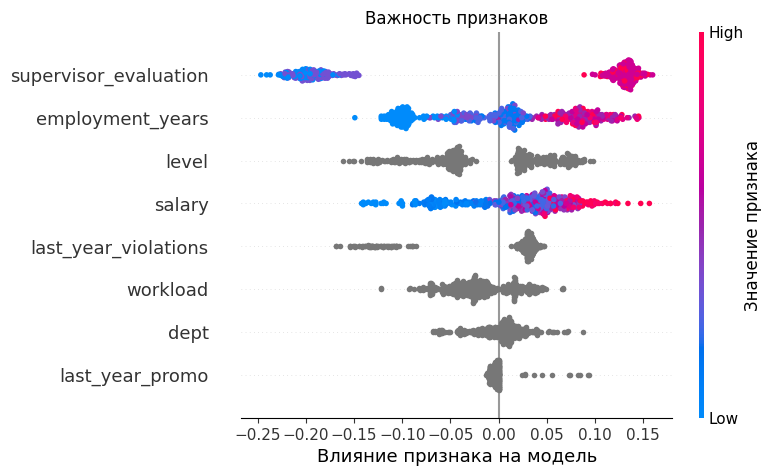

In [45]:
shap.summary_plot(shap_values, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel("Влияние признака на модель")
ax.set_title('Важность признаков')
cb_ax = fig.axes[1] 
cb_ax.set_ylabel("Значение признака")
plt.show()

Больше всего на удовлетворенность влияют оценка руководителя и количество лет в компании. Наименьшее влияние оказывают повышение за последний месяц и отдел. Если оценка руководителя 3 и ниже, стоит присмотреться к такому работнику, скорее всего у него низкая удовлетворенность в компании.

## Исследование №2

### Загрузка данных

Сохраним новые данные, тестовые признаки возьмем из прошлого исследования

In [47]:
data_second = pd.read_csv('datasets/train_quit.csv')
X_test_second = X_test_first
y_test_second = pd.read_csv('datasets/test_target_quit.csv')

In [48]:
display(data_second.head(5))
data_second.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [49]:
display(y_test_second.head(5))
y_test_second.info()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Названия столбцов записаны корректно, в этот раз пропуски отсутствуют

### Предобработка данных

Проверим id на явные дубликаты, отсортируем новый таргет по id и проверим что они совпадают с тестовыми

In [50]:
data_second['id'].duplicated().sum()

0

In [51]:
y_test_second = y_test_second.sort_values(by='id').reset_index(drop=True) 
(X_test_second['id'] == y_test_second['id']).sum()

2000

Проверим названия категорий в новом датасете на опечатки

In [52]:
display(
    data_second['dept'].unique(),
    data_second['level'].unique(),
    data_second['workload'].unique(),
    data_second['last_year_promo'].unique(),
    data_second['last_year_violations'].unique(),
    data_second['quit'].unique()
)

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

array(['middle', 'junior', 'sinior'], dtype=object)

array(['high', 'medium', 'low'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['no', 'yes'], dtype=object)

array(['no', 'yes'], dtype=object)

Мы загрузили новые данные для задачи классификации и отсортировали датафрейм с таргетным признаком

### Исследовательский анализ данных

Добавим в тестовые данные признак удовлетворенности из прошлого исследования, для тестовых данных предскажем этот признак лучшей моделью из прошлого исследования

In [53]:
X_test_second['job_satisfaction_rate'] = \
grid_search_tree_const.best_estimator_.predict(
    X_test_second[num_columns + cat_columns]
)
data_second['job_satisfaction_rate'] = \
grid_search_tree_const.best_estimator_.predict(
    data_second[num_columns + cat_columns]
)
display(X_test_second.head(3))
data_second.head(3)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,100298,hr,junior,low,2,no,no,4,19200,0.880000
1,100480,marketing,junior,low,4,no,no,4,16800,0.852000
2,100503,purchasing,middle,high,5,no,no,4,55200,0.777778


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.606667
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.821905
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.337500


Посмотрим на описание новых данных

In [54]:
data_second.drop(columns='id').describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000,0.537742
std,2.541852,1.004049,15152.415163,0.217163
min,1.000000,1.000000,12000.000000,0.060000
25%,2.000000,3.000000,22800.000000,0.350000
50%,3.000000,4.000000,30000.000000,0.540000
75%,6.000000,4.000000,43200.000000,0.690000
max,10.000000,5.000000,96000.000000,0.987500


Аномалий не обнаружено, выбросы как и раньше в зарплате. Как и в прошлом исследовании сравним тренировочные и тестовые данные

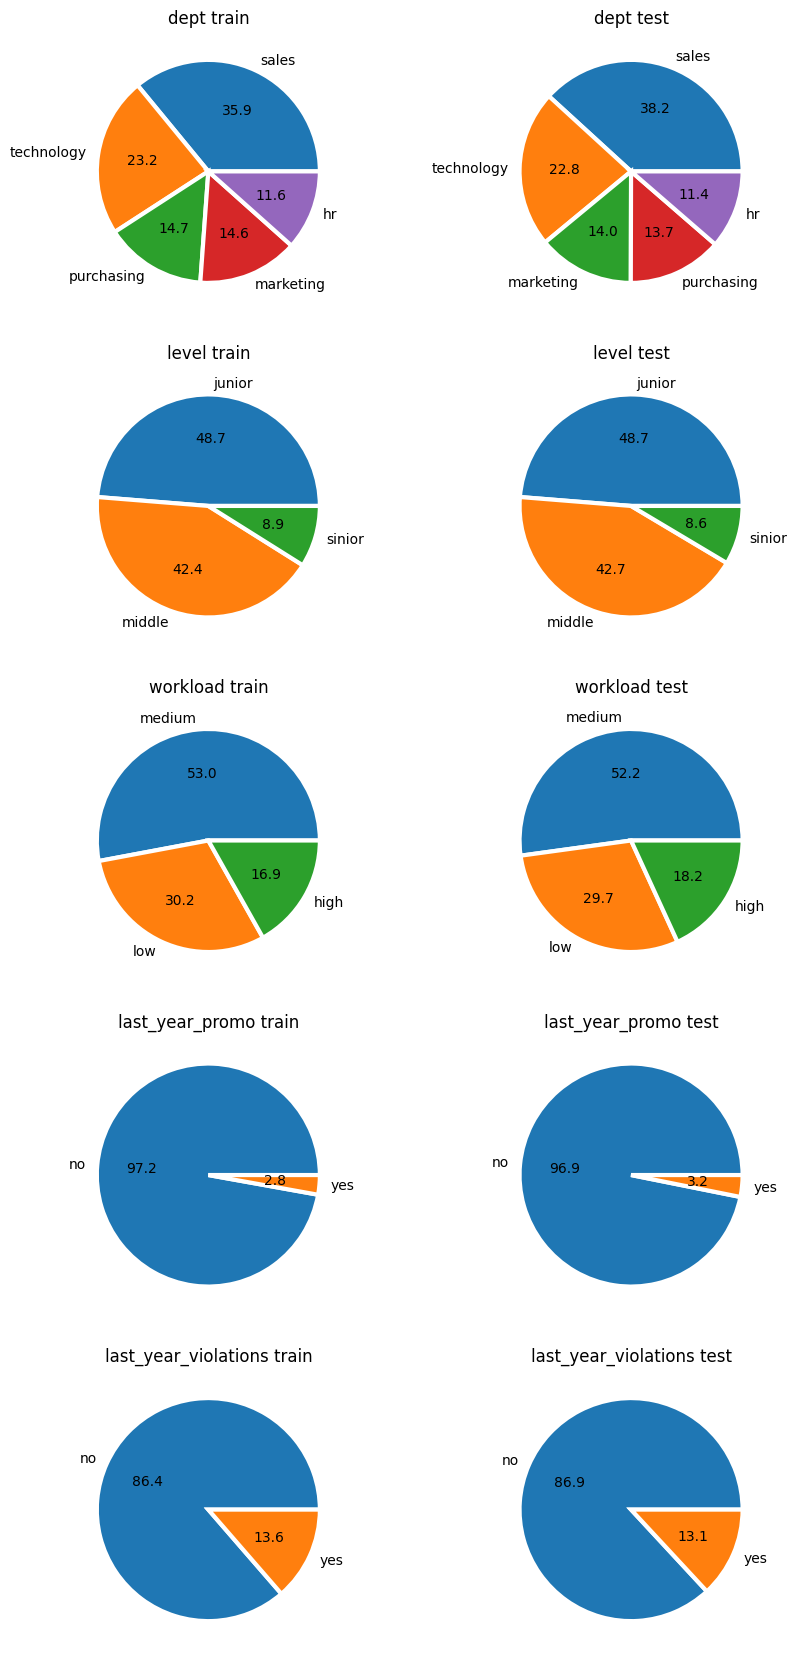

In [55]:
col = [
    'dept', 'level', 'workload', 
    'last_year_promo', 'last_year_violations'
]
plt.figure(figsize=(10, 21))
for i in range(0, len(col)*2, 2):
    for j in range(0, 2):
        plt.subplot(len(col), 2, (i+j+1))
        if j == 0:
            pie(data_second, col[int(i/2)], ' train')
        else:
            pie(X_test_second, col[int(i/2)], ' test')
plt.show()  

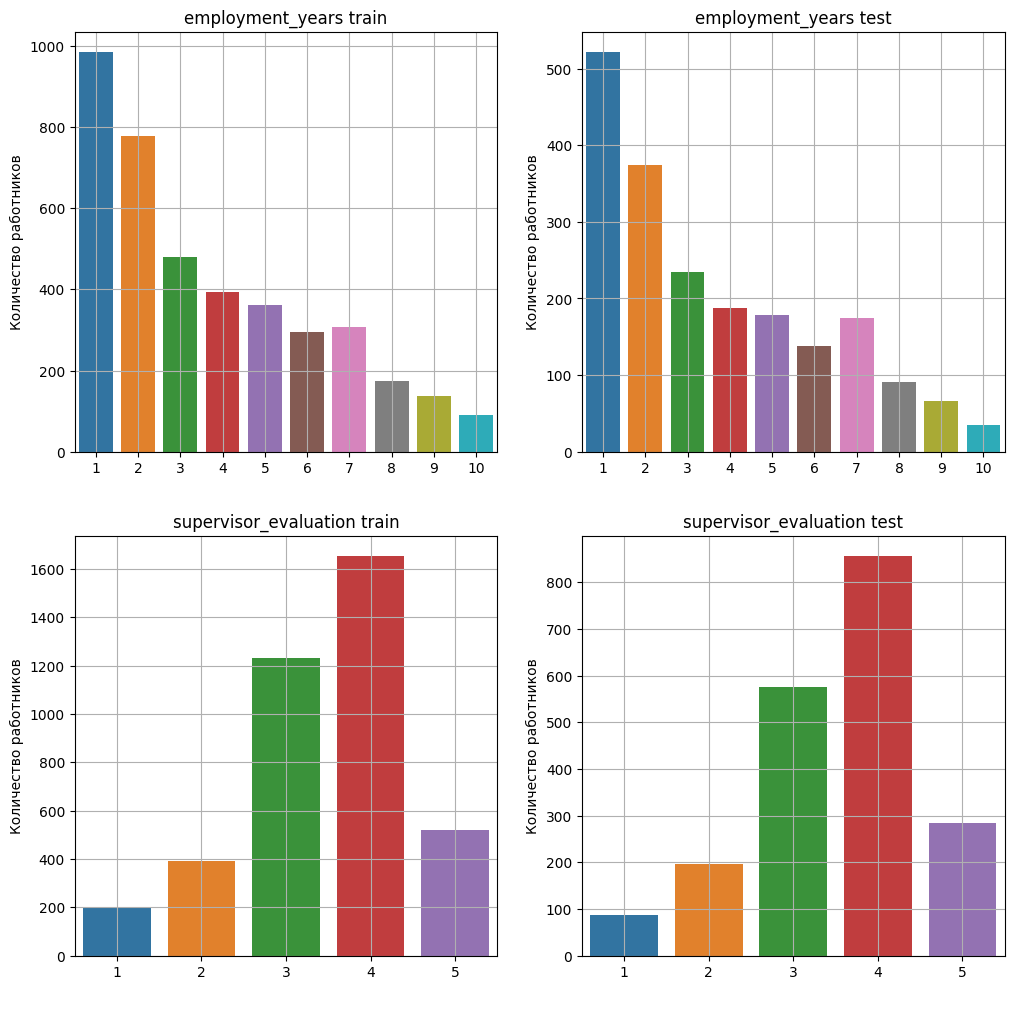

In [56]:
col = ['employment_years', 'supervisor_evaluation']
plt.figure(figsize=(12, 12))
for i in range(0, len(col)*2, 2):
    for j in range(0, 2):
        plt.subplot(len(col), 2, (i+j+1))
        if j == 0:
            bar(data_second, col[int(i/2)], ' train')
        else:
            bar(X_test_second, col[int(i/2)], ' test')
plt.show() 

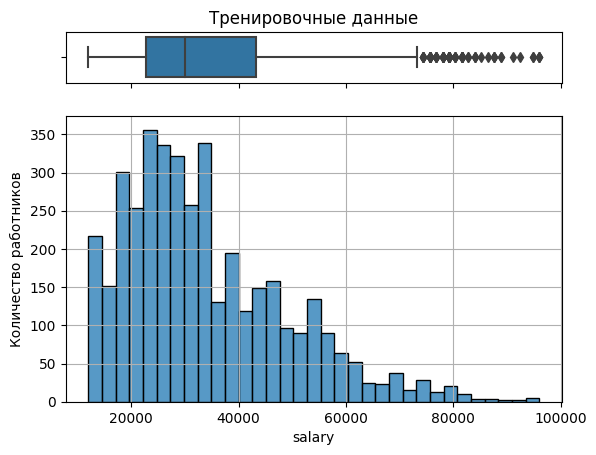

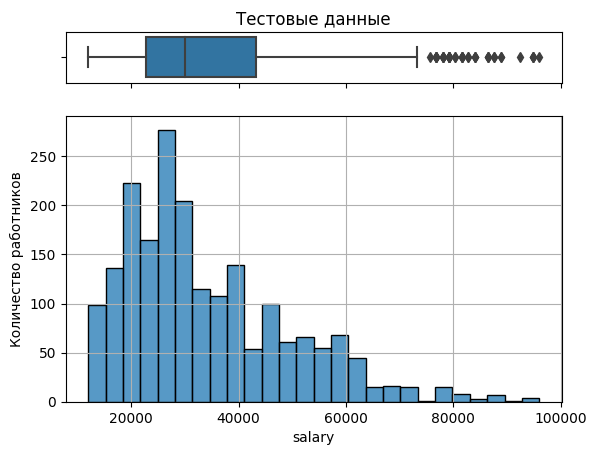

In [57]:
dia_hist_box(data_second, 'salary', 'Тренировочные данные')
dia_hist_box(X_test_second, 'salary', 'Тестовые данные')

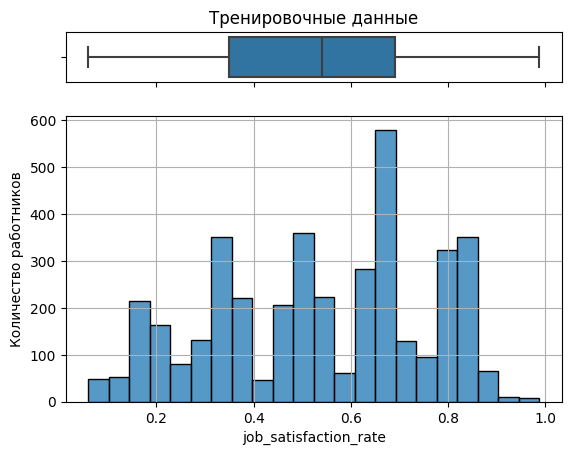

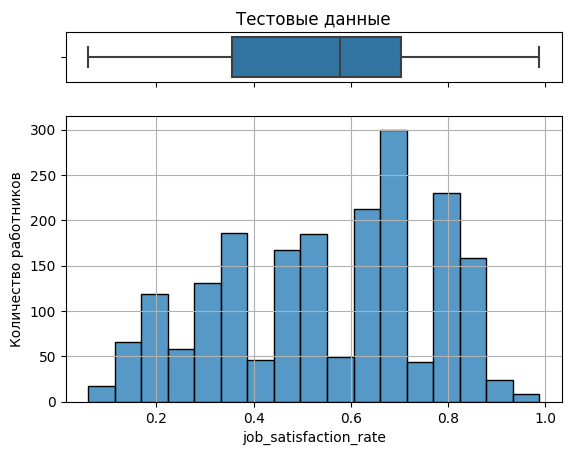

In [58]:
dia_hist_box(data_second, 'job_satisfaction_rate', 'Тренировочные данные')
dia_hist_box(X_test_second, 'job_satisfaction_rate', 'Тестовые данные')

Признаки распределены схожим образом, можно не бояться переобучения модели. Как и в прошлый раз в зарплате наблюдаются выбросы, значит стоит использовать робастные инструменты. Посмотрим на таргетный признак

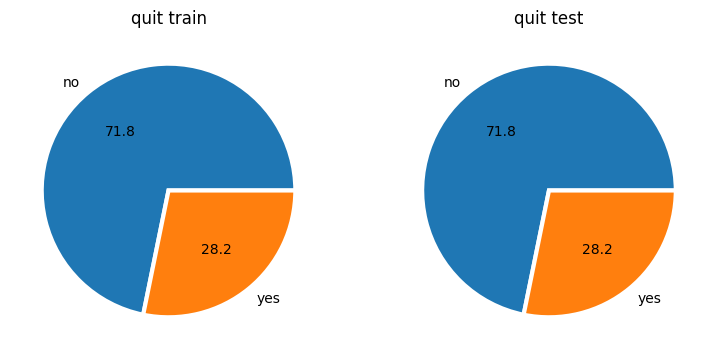

In [59]:
plt.figure(figsize=(9, 5))
plt.subplot(121)
pie(data_second, 'quit', ' train')
plt.subplot(122)
pie(y_test_second, 'quit', ' test')
plt.show()

В обоих случаях наблюдается дисбаланс классов. Для выбора лучшей модели выбрана метрика ROC-AUC, устойчивая к дисбалансу. Выделять часть тренировочных данных для теста не требуется, следовательно нет необходимости стратифицировать такую выборку

Составим портрет ушедшего сотрудника и проверим, влияет ли на отток кадров уровень удовлетворенности. Для этого сравним распределение по категориям ушедших и оставшихся сотрудников, рассмотрим долю уволившихся сотрудников по разным категориям. Также рассмотрим распределение по отдельным и парным количественным признакам

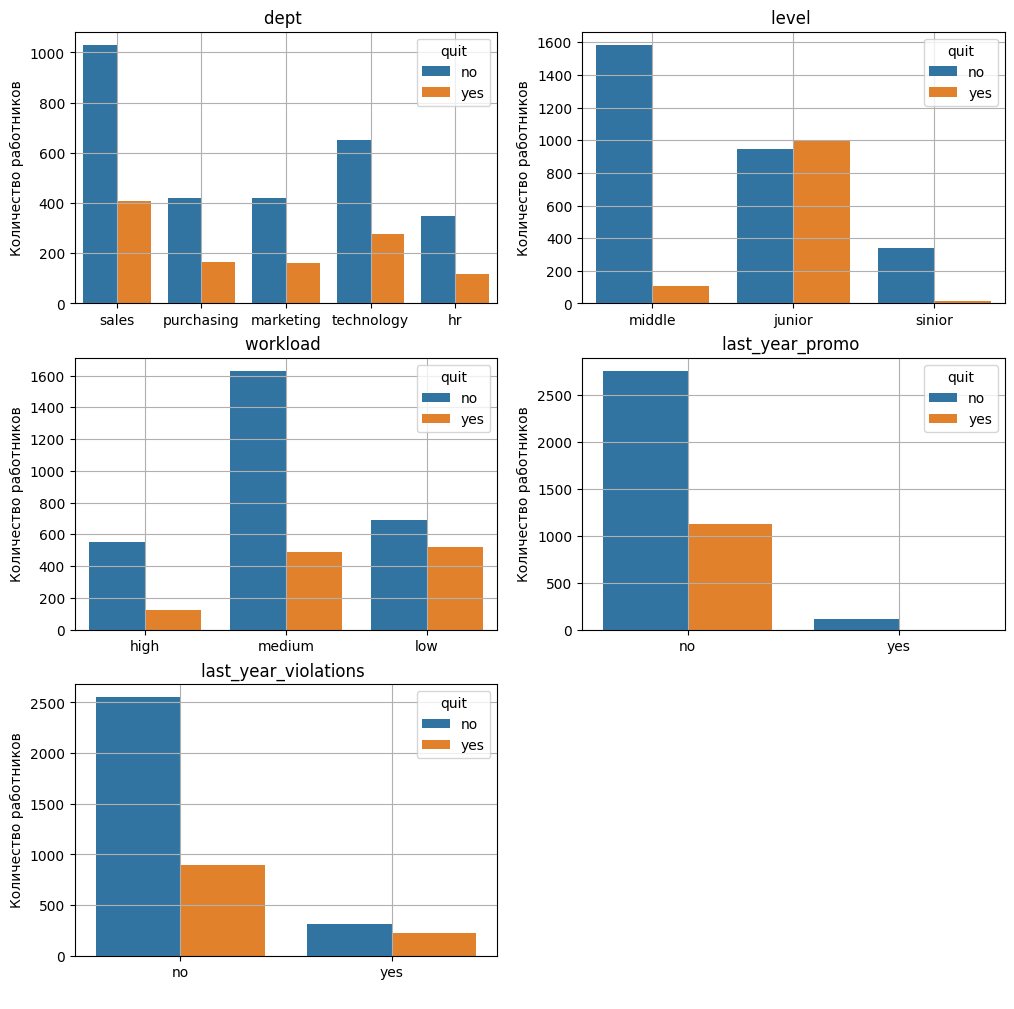

In [60]:
col = [
    'dept', 'level', 'workload', 
    'last_year_promo', 'last_year_violations'
]
plt.figure(figsize=(12, 12))
for i in range(0, len(col)):
           plt.subplot(3, 2, (i+1))
           bar(data_second, col[i], ' ', hue='quit')
plt.show()   

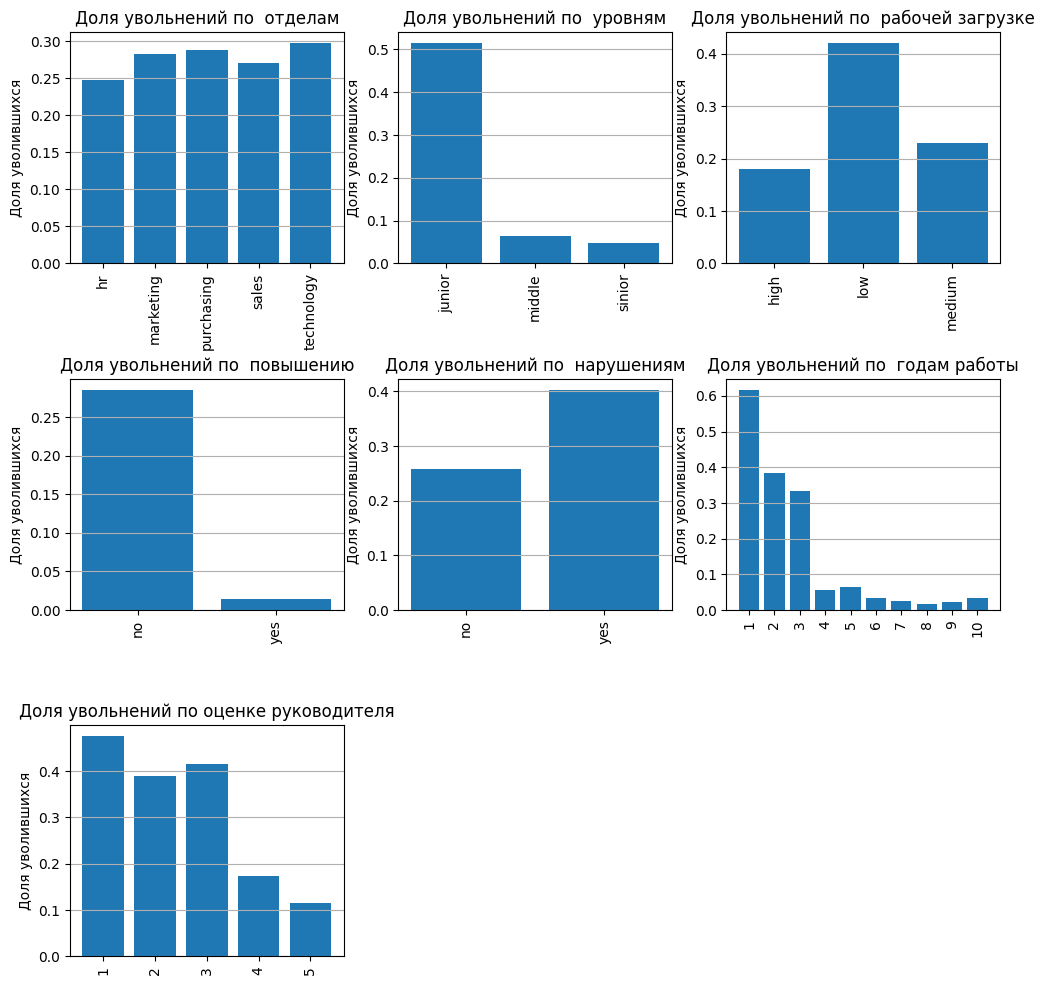

In [61]:
col = [
    'dept', 'level', 'workload', 
    'last_year_promo', 'last_year_violations',
    'employment_years', 'supervisor_evaluation'
]
titles = [
    ' отделам', ' уровням', ' рабочей загрузке', 
    ' повышению', ' нарушениям', 
    ' годам работы', 'оценке руководителя'
]
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
for i in range(0, len(col)):
           plt.subplot(3, 3, (i+1))
           dia_bar_pct(col[i], titles[i])
plt.show()

Сильно выделяется зависимость от уровня: почти все уволившиеся работники уровня junior, также больше половины работников этого уровня ушли из компании. 

Кроме того, несколько слабее влияет уровень загруженности работников: чаще уходят люди с низкой трудовой загрузкой.

Среди небольшого числа работников, нарушивших правила за последни год, многие ушли из компании.

Значительная доля тех, кто не получал повышения, уволились

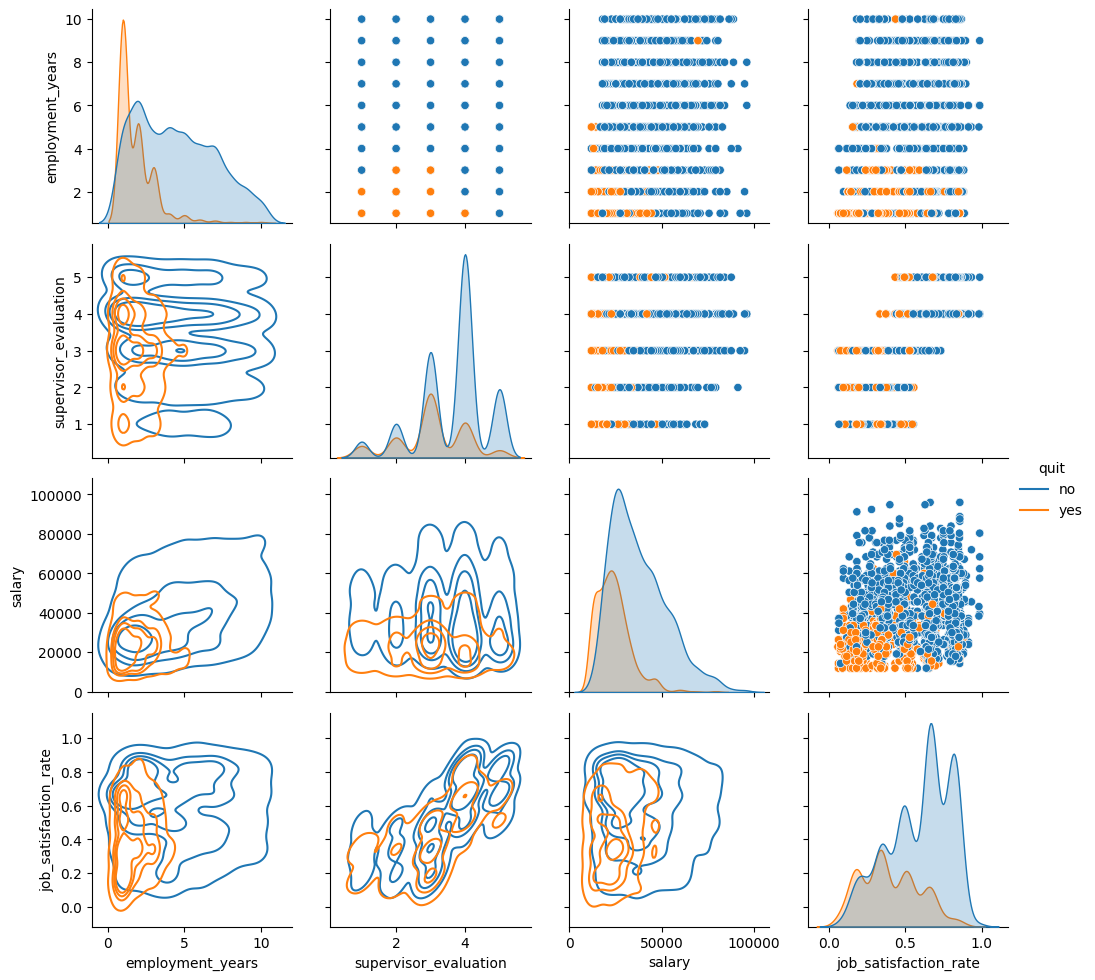

In [62]:
g = sns.PairGrid(data_second.drop(columns='id'), hue="quit", diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot, levels=5)
g.map_diag(sns.kdeplot, fill=True)
g.add_legend()
plt.show()


Ушедшие сотрудники почти всегда проработали в компании менее 4 лет, причем они были менее удовлетворены в первые годы, тогда как оставшиеся работники в начале карьеры показывают максимальную удовлетворенность, снижающуюся со временем. 

Уволившиеся сотрудники редко получают оценку руководителя 4 и выше.



При низкой зарплате уровень удовлетворенности ушедших сотрудников ниже, а средняя зарплата и средний уровень удовлетворенности меньше.

Можно сделать вывод, что признак удовлетворенности положительно повлияет на предсказания модели

### Обучение модели

Закодируем целевой признак. 1=yes, 0=no

In [63]:
label_encoder = LabelEncoder()
label_encoder.fit(data_second['quit'])
data_second['target'] = label_encoder.transform(data_second['quit'])
display(data_second[['quit', 'target']].head(1))

,quit,target
0,no,0


Создадим списки категориальных и количественных переменных, исключив id и оба целевых признака, зададим новые тренировочные и тестовые X и y, трансформировав при этом тестовый таргет

In [64]:
cat_columns = data_second.select_dtypes(exclude='number').drop(columns='quit').columns.tolist()
num_columns = data_second.select_dtypes(include='number').drop(columns=['id', 'target']).columns.tolist()
X = data_second[num_columns + cat_columns]
y = data_second['target']
display(X.shape, y.shape)

(4000, 9)

(4000,)

In [65]:
X_test = X_test_second[num_columns + cat_columns]
y_test = label_encoder.transform(y_test_second['quit'])
display(X_test.shape)
display(y_test[0], y_test_second.head(1))

(2000, 9)

0

,id,quit
0,100298,no


In [66]:
data_second.head(1)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate,target
0,723290,sales,middle,high,2,no,no,4,54000,no,0.606667,0


Создадим два пайплайна для замены пропусков на заглушку и самое частое значение, добавим после предобработки селектор SelectKBest для отбора признаков. Поскольку имеется много данных, можно использовать метод взаимной информации, который находит все виды зависимостей

In [67]:
pipe_final_mf_fs = Pipeline([
    ('preprocessor', data_preprocessor_mf),
    ('feature_selection', SelectKBest(score_func=mutual_info_classif)),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [68]:
pipe_final_const_fs = Pipeline([
    ('preprocessor', data_preprocessor_const),
    ('feature_selection', SelectKBest(score_func=mutual_info_classif)),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Для задачи классификации подходят логистическая регрессия, метод ближайших соседей, метод опорных векторов и дерево решений - классификатор. Подберем параметры отдельно для дерева и всех остальных, отдельно для разных стратегий обработки пропусков. Как и раньше, добавим робастный скейлер

In [69]:
param_grid_dtc = {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(6, 16, 2),
        'models__min_samples_leaf': range(1, 15, 2),
        'feature_selection__k': ['all'],
        'preprocessor__num': [StandardScaler(), RobustScaler()]  
}

In [70]:
param_grid = [

    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20, 3),
        'feature_selection__k': ['all'],
        'preprocessor__num': [StandardScaler(), RobustScaler()]   
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': np.arange(0.1, 3, 0.5),
        'feature_selection__k': ['all'],
        'preprocessor__num': [StandardScaler(), RobustScaler()]  
    },

    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': np.arange(0.1, 4, 0.5),
        'feature_selection__k': ['all'],
        'preprocessor__num': [StandardScaler(), RobustScaler()]  
    }
]

In [71]:
grid_search_mf = GridSearchCV(
    pipe_final_mf_fs, 
    param_grid, 
    scoring='roc_auc',
    n_jobs=-1
)
grid_search_mf.fit(X, y)
print('Лучшая модель и её параметры:\n\n', grid_search_mf.best_estimator_)
print('Knn, svc, logreg, mf')
print ('Метрика лучшей модели на кросс-валидации:', grid_search_mf.best_score_)
print (
    'Метрика лучшей модели на тестовых данных:', 
    roc_auc_score(y_test, grid_search_mf.best_estimator_.predict_proba(X_test)[:,1])
)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                     

In [72]:
grid_search_const = GridSearchCV(
    pipe_final_const_fs, 
    param_grid, 
    scoring='roc_auc',
    n_jobs=-1
)
grid_search_const.fit(X, y)
print('Лучшая модель и её параметры:\n\n', grid_search_const.best_estimator_)
print('Knn, svc, logreg, constant')
print ('Метрика лучшей модели на кросс-валидации:', grid_search_const.best_score_)
print (
    'Метрика лучшей модели на тестовых данных:', 
    roc_auc_score(y_test, grid_search_const.best_estimator_.predict_proba(X_test)[:,1])
)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                     

In [73]:
grid_search_mf_dtc = GridSearchCV(
    pipe_final_mf_fs, 
    param_grid_dtc, 
    scoring='roc_auc',
    n_jobs=-1
)
grid_search_mf_dtc.fit(X, y)
print('Лучшая модель и её параметры:\n\n', grid_search_mf_dtc.best_estimator_)
print('Tree, mf')
print ('Метрика лучшей модели на кросс-валидации:', grid_search_mf_dtc.best_score_)
print (
    'Метрика лучшей модели на тестовых данных:', 
    roc_auc_score(y_test, grid_search_mf_dtc.best_estimator_.predict_proba(X_test)[:,1])
)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                     

In [74]:
grid_search_const_dtc = GridSearchCV(
    pipe_final_const_fs, 
    param_grid_dtc, 
    scoring='roc_auc',
    n_jobs=-1
)
grid_search_const_dtc.fit(X, y)
print('Лучшая модель и её параметры:\n\n', grid_search_const_dtc.best_estimator_)
print('Tree, constant')
print ('Метрика лучшей модели на кросс-валидации:', grid_search_const_dtc.best_score_)
print (
    'Метрика лучшей модели на тестовых данных:', 
    roc_auc_score(y_test, grid_search_const_dtc.best_estimator_.predict_proba(X_test)[:,1])
)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                     

Лучше всего себя показал метод опорных векторов, хотя дерево решений тоже прошло порог. Попробуем ещё сильнее улучшить модель, подобрав дополнительные параметры только для неё

In [75]:
param_grid = {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': np.arange(20, 23, 1),
        'models__gamma': np.arange(0.02, 0.05, 0.01),
        'feature_selection__k': ['all'],
        'preprocessor__num': [RobustScaler()]  
}

In [76]:
grid_search_const = GridSearchCV(
    pipe_final_const_fs, 
    param_grid, 
    scoring='roc_auc',
    n_jobs=-1
)
grid_search_const.fit(X, y)
print('Лучшая модель и её параметры:\n\n', grid_search_const.best_estimator_)
print('svc, constant')
print ('Метрика лучшей модели на кросс-валидации:', grid_search_const.best_score_)
print (
    'Метрика лучшей модели на тестовых данных:', 
    roc_auc_score(y_test, grid_search_const.best_estimator_.predict_proba(X_test)[:,1])
)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                     

Итоговая метрика получилась 0,93 на методе опорных векторов

### Интерпретация модели

Аналогично первому исследованию посчитаем shap 

In [77]:
X_summary = shap.sample(X, 10)
X_test_summary = X_test.iloc[0:500]

In [78]:
explainer = shap.KernelExplainer(
    grid_search_const.best_estimator_.predict, 
    X_summary, 
    keep_index=True
)
shap_values = explainer(X_test_summary)

  0%|          | 0/500 [00:00<?, ?it/s]

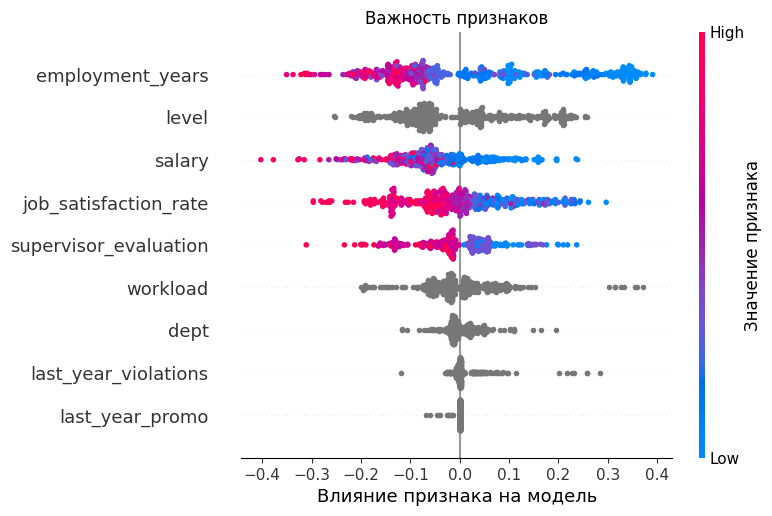

In [79]:
shap.summary_plot(shap_values, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel("Влияние признака на модель")
ax.set_title('Важность признаков')
cb_ax = fig.axes[1] 
cb_ax.set_ylabel("Значение признака")
plt.show()

Сильное влияние на отток кадров оказывает время, проведенное в кампании, удовлетворенность, оценка начальника и зарплата. Эти выводы подтверждают наше видение уволившегося сотрудника на основе данных. Стоит пристально следить за удовлетворенностью сотрудников и отношениями в коллективе, особенно в первые годы.

## Итоговые выводы

### Исходные данные и обработка

Для обучения моделей было получено 5 датасетов: два с различными признаками работников компании, в том числе и целевыми признаками. Два с целевыми признаками для теста и один с входными признаками для теста. Всего 4000 обучающих и 2000 тестовых строк.

В результате обработки данных были выявлены несколько пропусков, которые будут обработаны при дальнейшем исследовании, убраны пробелы и отсортированы в одинаковом порядке тренировочные данные

### Выводы исследования №1

#### Исследовательский анализ

Выяснилось, что тренировочные и тестовые данные распределены схожим образом, следовательно можно не бояться быстрого переобучения модели. Также был обнаружен признак с выбросами, зарплата, а значит стоит использовать робастные инструменты. В таких категориях как замечания и повышения за последний год имеется сильный дисбаланс

#### Корреляционный анализ

При оценке корреляции как количественных, так и категориальных признаков мультиколлинеарность не была обнаружена, при этом некоторые признаки почти не влияют на целевой

#### Выбор и обучение модели

Для оценки работы модели была реализована метрика SMAPE. 

Предсказание уровня удовлетворенности является задачей регрессии, поэтому были выбраны модели линейной регресси и регрессионного дерева решений. Для обработки пропусков были применены два метода: замена на самое часто встречающееся значение и на заглушку. Для защиты от выбросов помимо стандартного скейлера для обработки числовых признаков был использован робастный скейлер. Также для дерева решений подобраны гиперпараметры. Для поиска самой лучшей комбинации вышеперечисленных параметров был использован долгий, но максимально эффективный поиск по сетке, оценивающий требуемую метрику SMAPE.

В результате было выбрано дерево решений, замена пропусков на заглушки и робастный скейлер. Итоговая метрика на тестовых данных составила 13,6%, что соответствует поставленному условию не более 15%

#### Интерпретация модели

Для объяснения принятия решений моделью были рассчитаны значения Шепли. Согласно им больше всего на удовлетворенность влияют оценка руководителя и количество лет в компании. Наименьшее влияние оказывают повышение за последний месяц и отдел, в котором человек работает. Если оценка руководителя 3 и ниже, стоит присмотреться к такому работнику, скорее всего у него низкая удовлетворенность в компании.

### Выводы исследования №2

#### Предобработка данных

В тренировочных данных для второго исследования не было пропусков. Значения целевого признака были отсортированы в соответствии с тестовым набором входных признаков

#### Исследовательский анализ

В тестовые данные был добавлен признак удовлетворенности из предоставленного для прошлого исследования датасета, для тестовых данных предскажем этот признак лучшей регрессионной моделью. 

Тренировочные данные распределены схожим образом с признаками из предыдущего исследования. Они похожи на тестовые, что позволяет не бояться переобучения. Как и раньше, имеются выбросы в зарплате, что подталкивает к использованию робастных инструментов.

В тренировочном и тестовом таргете наблюдается дисбаланс классов. Выбор ROC-AUC в качестве ключевой метрики является хорошим решением, она устойчива к дисбалансу.

**Портрет уволившегося сотрудника:** почти все уволившиеся работники уровня junior, также больше половины работников этого уровня ушли из компании. Кроме того, несколько слабее влияет уровень загруженности работников: чаще уходят люди с низкой трудовой загрузкой. Среди небольшого числа работников, нарушавших правила за последни год, многие ушли из компании.

#### Выбор и обучение модели

Предсказание ухода или не ухода сотрудника является задачей бинарной классификации. Для неё подойдут модели логистической регрессии, k ближайших соседей, опорных векторов и дерево решений - классификатор. Как и в прошлый раз, путем подбора стратегии обработки пропусков, скейлера и параметров моделей, а также с помощью подбора оптимального количества признаков, была найдена лучшая модель. 

Под заданный порог ROC-AUC на тестовых данных не менее 0,91 подошли дерево решений и метод опорных векторов. В результате дополнительной настройки параметров итоговое значение метрики достигло 0,93

#### Интерпретация модели

Как и в предыдущем случае, были найдены значения Шепли. Самое сильное влияние на отток кадров оказывает время, проведенное в кампании, удовлетворенность, оценка начальника и зарплата. Это подтверждает выводы о портрете уволившегося клиента на основе данных. Стоит пристально следить за удовлетворенностью сотрудников и отношениями в коллективе, особенно в первые годы.

### Рекомендации по модели

Поскольку тренировочные и тестовые данные были распределены схожим образом, точность модели может упасть на новых отличающихся данных. В таком случае следует провести повторное обучение с учетом изменившихся данных. Также для настройки модели предсказания оттока кадров под более узкие задачи можно провести её настройку и задать целью другую метрику, например precision или recall. Для улучшения модели в целом стоит продолжать собирать данные, рассмотреть возможность расширить количество признаков, показывающих отношения в коллективе